In [1]:
#conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

Solving environment: ...working... unsuccessful initial attempt using frozen solve. Retrying with flexible solve.
Solving environment: ...working... unsuccessful attempt using repodata from current_repodata.json, retrying with next repodata source.
Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Behro\anaconda3

  added / updated specs:
    - pytorch
    - pytorch-cuda=11.7
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cuda-cccl-12.2.128         |                0         1.3 MB  nvidia
    cuda-cudart-11.7.99        |                0         1.4 MB  nvidia
    cuda-cudart-dev-11.7.99    |                0         711 KB  nvidia
    cuda-cupti-11.7.101        |                0        10.2 MB  nvidia
    cuda-libraries-11.7.1      |                0           1 KB  nvidia
    cuda-libraries-dev-11.7.1  

# Neural Network on FashionMNIST

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
#Downloading training data from open datasets
training_data = datasets.FashionMNIST(
    root="data",
    train= True,
    download= True,
    transform= ToTensor(),
)

#Downloading test data from open datasets
test_data = datasets.FashionMNIST(
    root="data",
    train= False,
    download= True,
    transform= ToTensor(),
)

In [3]:
batch_size = 64

#Create data loaders
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
    

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
#Get cpu, gpu, or mps device for training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#Define Model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
#We initialize the nn.Flatten layer to convert each 2D 28x28 image into 
#a contiguous array of 784 pixel values ( the minibatch dimension (at dim=0) is maintained).        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X,y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        #compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [6]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------------
loss: 2.311912 [   64/60000]
loss: 2.295335 [ 6464/60000]
loss: 2.266642 [12864/60000]
loss: 2.264805 [19264/60000]
loss: 2.252598 [25664/60000]
loss: 2.215352 [32064/60000]
loss: 2.235569 [38464/60000]
loss: 2.196804 [44864/60000]
loss: 2.202709 [51264/60000]
loss: 2.169950 [57664/60000]
Test Error: 
 Accuracy: 39.9%, Avg loss: 2.157874 

Epoch 2
-------------------------------------
loss: 2.175372 [   64/60000]
loss: 2.167395 [ 6464/60000]
loss: 2.095861 [12864/60000]
loss: 2.119707 [19264/60000]
loss: 2.081452 [25664/60000]
loss: 2.004012 [32064/60000]
loss: 2.050193 [38464/60000]
loss: 1.963380 [44864/60000]
loss: 1.983858 [51264/60000]
loss: 1.908173 [57664/60000]
Test Error: 
 Accuracy: 59.6%, Avg loss: 1.901082 

Epoch 3
-------------------------------------
loss: 1.938675 [   64/60000]
loss: 1.911721 [ 6464/60000]
loss: 1.777064 [12864/60000]
loss: 1.828989 [19264/60000]
loss: 1.727530 [25664/60000]
loss: 1.657495 [32064/60000]
loss

In [ ]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name}  | Size: {param.size()}  | Values: {param[:2]} \n")

In [7]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [16]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
print(x)
print("------------------------------------------------------------------------------")
print(y)
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    print("..........................................................................")
    print(pred)
    
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

# Training some codes to learn pytorch

In [38]:
data = [[1,2],[3,4]]
x_data = torch.tensor(data)
x_ones = torch.zeros_like(x_data)
print(f"Ones Tensor: \n {x_ones}\n")
x_rand = torch.rand_like(x_data, dtype=torch.float)
print(f"Random Tensor: \n {x_rand}\n")

shape = (2,3)
rand_tensor = torch.randn(shape)
ones_tensor = torch.ones(shape,dtype=torch.int)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n{rand_tensor}\n")
print(f"Ones Tensor: \n{ones_tensor}\n")
print(f"Zeros Tensor: \n{zeros_tensor}\n")
print(f"Device tensor is stored on: {rand_tensor.device}")

Ones Tensor: 
 tensor([[0, 0],
        [0, 0]])

Random Tensor: 
 tensor([[0.8639, 0.8197],
        [0.1821, 0.8583]])

Random Tensor: 
tensor([[-1.0477,  0.0328, -0.6242],
        [-0.1088, -0.9846,  0.2399]])

Ones Tensor: 
tensor([[1, 1, 1],
        [1, 1, 1]], dtype=torch.int32)

Zeros Tensor: 
tensor([[0., 0., 0.],
        [0., 0., 0.]])

Device tensor is stored on: cpu


In [63]:
tensor = torch.ones(4,4)*5
print(f"First row: {tensor[0]}")
print(f"First column: {tensor[:, 0]}")
print(f"Last row: {tensor[:,-1]}\n")
tensor[:,-1] = 0
print(tensor)
t1 = torch.cat([tensor, tensor, tensor], dim = 0)
print(f"\n{t1}")

y1 = tensor @ tensor.T
print(f"\n{y1}")

y2 = tensor * tensor
print(f"\n{y2}")

agg = tensor.sum()
agg_item = agg.item()
print(f"\n{agg}  {type(agg)}\n")

tensor +=2
print(tensor)

First row: tensor([5., 5., 5., 5.])
First column: tensor([5., 5., 5., 5.])
Last row: tensor([5., 5., 5., 5.])

tensor([[5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.]])

tensor([[5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.],
        [5., 5., 5., 0.]])

tensor([[75., 75., 75., 75.],
        [75., 75., 75., 75.],
        [75., 75., 75., 75.],
        [75., 75., 75., 75.]])

tensor([[25., 25., 25.,  0.],
        [25., 25., 25.,  0.],
        [25., 25., 25.,  0.],
        [25., 25., 25.,  0.]])

60.0  <class 'torch.Tensor'>

tensor([[7., 7., 7., 2.],
        [7., 7., 7., 2.],
        [7., 7., 7., 2.],
        [7., 7., 7., 2.]])


# FasionMNIST

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [10]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform= ToTensor()
)

test_data = datasets.FashionMNIST(
    root="root",
    train=False,
    download=True,
    transform=ToTensor()
)

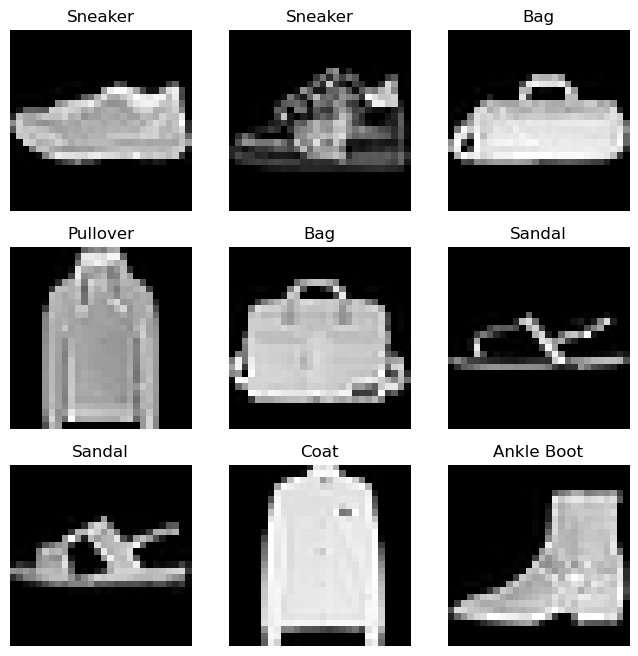

torch.Size([1, 28, 28])
torch.Size([28, 28])


In [13]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()
print(img.shape)
print(img.squeeze().shape)


# Creating a custom Dataset for your files

In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

In [4]:
# To make a custom Dataset, three functions are neccessary: __init__,__len__,__getitem__
# images are stored in img_dir
# lables are stored in a csv file annotations_file
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.ilococ[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# Preparing your data for training with DataLoaders

In [5]:
from torch.utils.data import DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


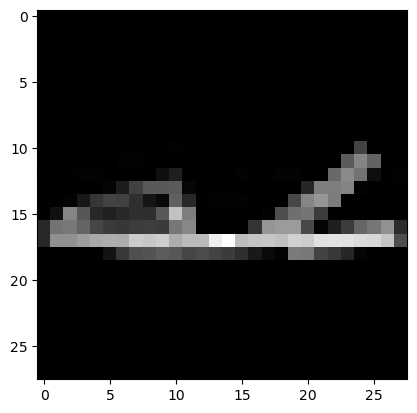

Label: 5


In [11]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#Display image and label
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [1]:
import torch

In [8]:
#In this network, w and b are parameters, which we need to optimize.
#Thus, we need to be able to compute the gradients of loss function 
#with respect to those variables.
#In order to do that, we set the requires_grad property of those tensors.

x = torch.ones(5)
y = torch.zeros(3)
w = torch.randn(5, 3, requires_grad=True)
print(w)
b = torch.randn(3, requires_grad=True)
print(b)
z = torch.matmul(x, w) + b
print(z)
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)
print(loss)

print(f"Gradient function for z = {z.grad_fn}\n")
print(f"Gradient function for loss = {loss.grad_fn}\n")

#To optimize weights of parameters in the neural network,
#we need to compute the derivatives of our loss function 
#with respect to parameters, namely, we need ∂loss/∂w∂
#and ∂loss/∂b under some fixed values of x and y. 
loss.backward()
print(w.grad)
print(b.grad)

tensor([[-0.1333, -0.7295, -0.2558],
        [-0.3451, -1.3560, -0.7223],
        [-1.0357, -0.5813,  0.8214],
        [ 1.2227, -0.3119, -0.5760],
        [-1.0146, -0.6719, -0.3236]], requires_grad=True)
tensor([-1.1897, -1.9679,  1.4501], requires_grad=True)
tensor([-2.4956, -5.6185,  0.3939], grad_fn=<AddBackward0>)
tensor(0.3307, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Gradient function for z = <AddBackward0 object at 0x0000022EEEB417B0>

Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x0000022EEEB40AC0>

tensor([[0.0254, 0.0012, 0.1991],
        [0.0254, 0.0012, 0.1991],
        [0.0254, 0.0012, 0.1991],
        [0.0254, 0.0012, 0.1991],
        [0.0254, 0.0012, 0.1991]])
tensor([0.0254, 0.0012, 0.1991])
